# NCI Weather Bench  - 10m_v_component_of_wind

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import dask.array as da
import glob
import matplotlib as mpl
import pprint 
import math
from random import random
from time import sleep
from multiprocessing.pool import Pool
import datetime

In [2]:
def hourly_rmse_a_year_single (y1, y2):
    rmse_list = []
    
    ds_wb  = xr.open_dataset( y1 )
    ds_NCI = xr.open_dataset( y2 ) 
    
    ds_wb  =  ds_wb[p_id]  
    ds_NCI =  ds_NCI[p_id] 
    
    date_times = ds_wb.time
    
    for dt in date_times:
        RMSE = -1.0
        try:
             RMSE = math.sqrt(  np.square(np.subtract(ds_wb.sel(time=dt) , ds_NCI.sel(time=dt))).mean() )
        except:
             RMSE = -0.1
        rmse_list.append(RMSE) 
        
    ds_wb.close()
    ds_NCI.close()    
    return rmse_list, date_times    


def hourly_rmse_multi_year_single (dir_wb, dir_NCI, p_name, p_id, year1, year2):

    all_years = []
    for year in range (year1, year2+1): 
        y1 = (dir_wb  + '/'+p_name+'/'+p_name+'_'+ str(year) + '_5.625deg.nc')
        y2 = (dir_NCI + '/'+p_name+'/'+p_name+'_'+ str(year) + '_5.625deg.nc')
        all_years.append ((y1,y2))             
       
    with Pool() as pool:                  
        rmse_list, date_times  = zip(* pool.starmap(hourly_rmse_a_year_single , all_years) )               
    #rmse_list, date_times =  hourly_rmse_a_year_single(all_years[0][0], all_years[0][1])       
    return rmse_list, date_times  
    
def display_hourly_rmse(time_list, err_list):  
    
    fig = plt.figure(figsize=(20, 8))
    grid = plt.GridSpec(5, 2, wspace=0.1, hspace=0.8)
    plt.subplot(grid[0:2, 0:2])
    plt.bar(time_list,  height = err_list, align='edge', width = 0.1, color='gray',label='RMSE' )
    plt.margins(x=0)
    #plt.xticks(time_list)
    plt.xlabel("Time")
    plt.ylabel("RMSE")
    plt.show()
    

In [3]:
%%time

NCI_dir = "/g/data/wb00/admin/testing/NCI_weatherbench/5.625deg"
wb_dir  = "/g/data/wb00/admin/testing/weatherbench/5.625deg"
p_name = '10m_v_component_of_wind'
p_id   = 'v10'
year1 = 1979
year2 = 2018

rmse_list, time_list = hourly_rmse_multi_year_single (wb_dir, NCI_dir, p_name, p_id, year1, year2)

CPU times: user 189 ms, sys: 280 ms, total: 469 ms
Wall time: 4min 21s


In [4]:
def display_hourly_rmse_double(time_list1, err_list1, time_list2, err_list2):  
    
    
    fig = plt.figure(figsize=(20, 8))
    grid = plt.GridSpec(8, 2, wspace=0.1, hspace=0.8)
    
    year = int(str(time_list1[0].values)[:4])
    plt.subplot(grid[0:2, 0:1])
    plt.bar(time_list1,  height = err_list1, align='edge', width = 0.1, color='gray',label='RMSE' )
    plt.margins(x=0)
    #plt.xticks(time_list)
    plt.xlabel("Date")
    plt.ylabel("RMSE")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.title(year)
    plt.xlim([datetime.date(year, 1, 1), datetime.date(year+1, 1, 1)])
    
    year = int(str(time_list2[0].values)[:4])
    plt.subplot(grid[0:2, 1: ])
    plt.bar(time_list2,  height = err_list2, align='edge', width = 0.1, color='gray',label='RMSE' )
    plt.margins(x=0)
    #plt.xticks(time_list)
    plt.xlabel("Date")
    #plt.ylabel("RMSE")  
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.title(year )
    plt.xlim([datetime.date(year, 1, 1), datetime.date(year+1, 1, 1)])
    
    plt.show()       

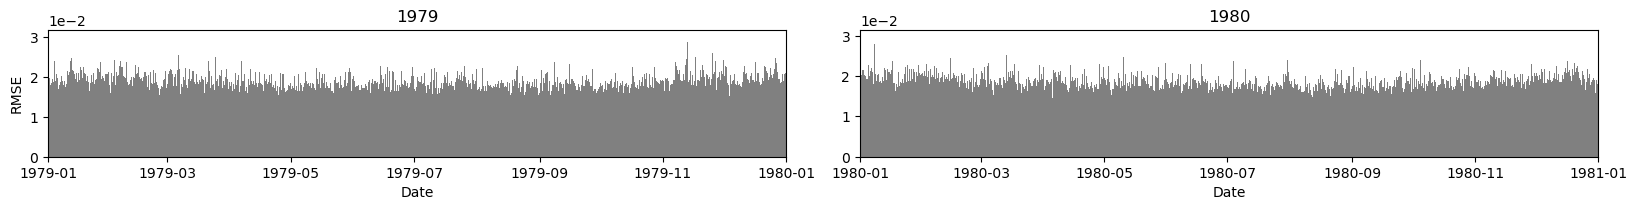

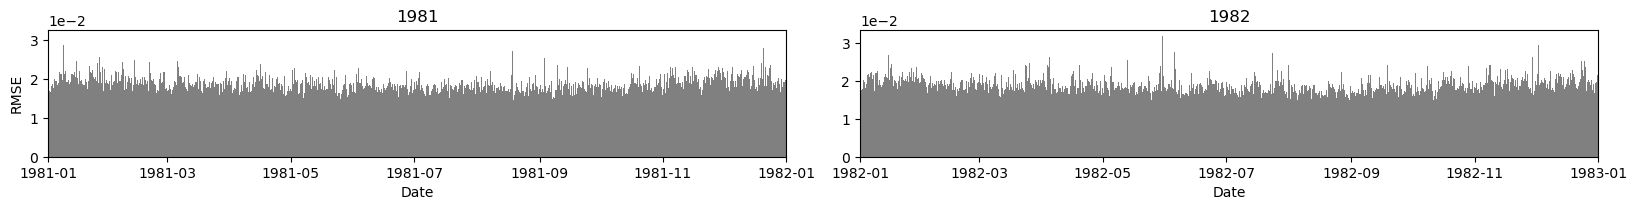

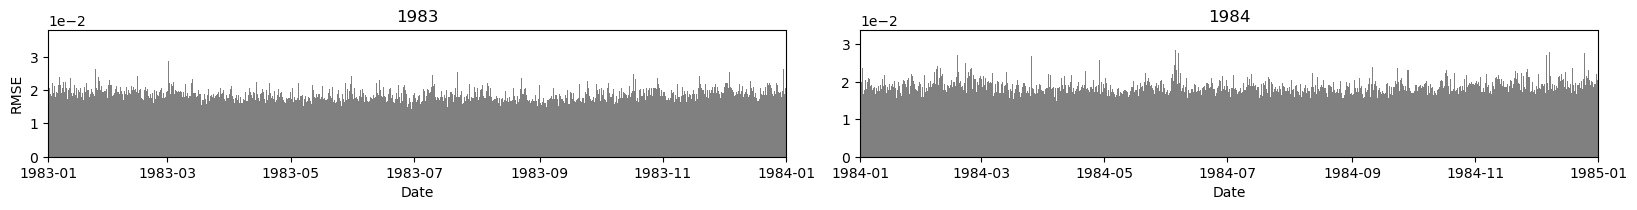

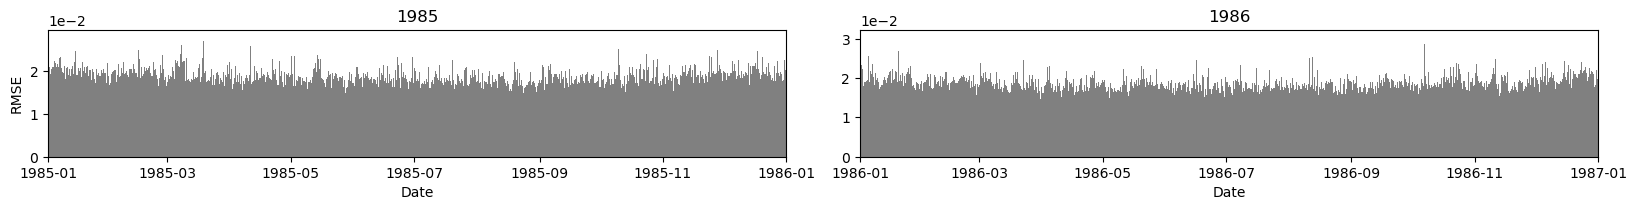

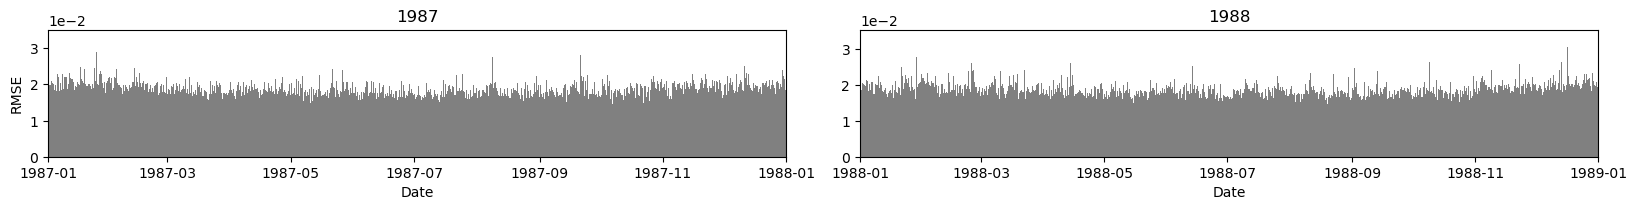

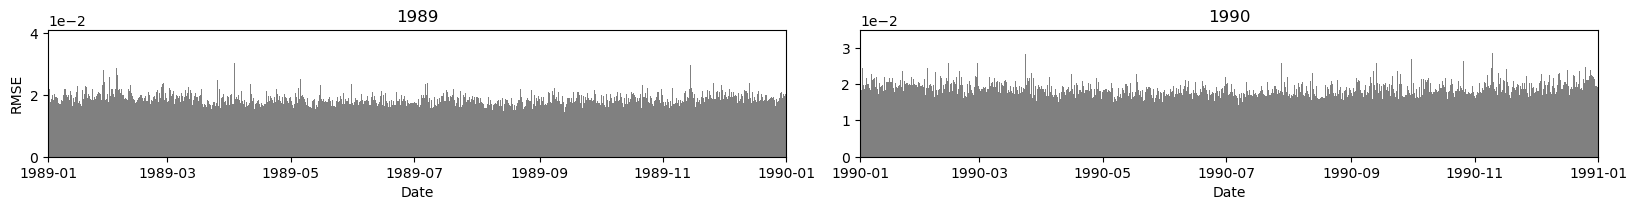

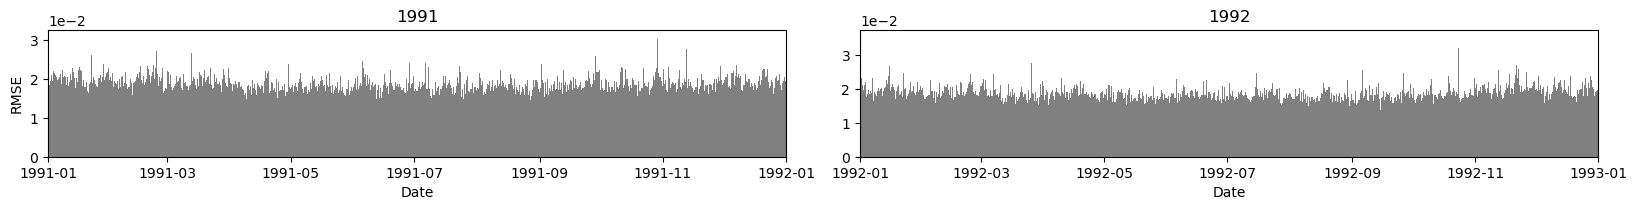

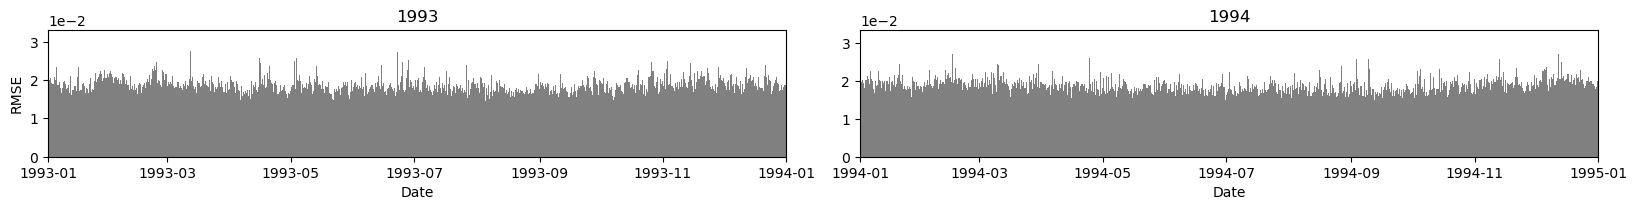

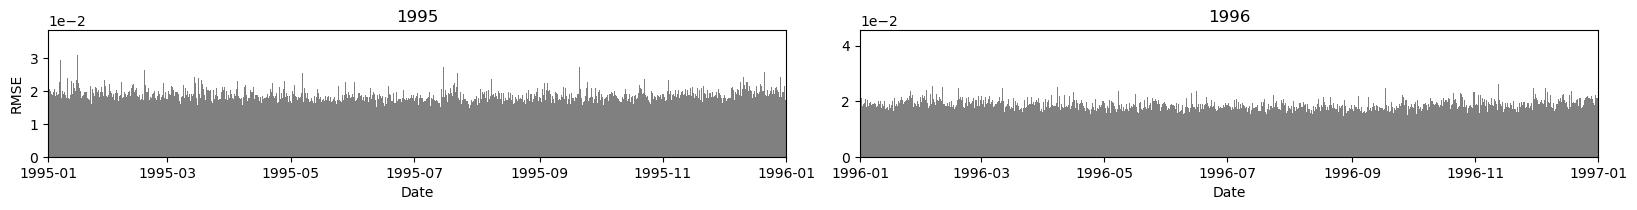

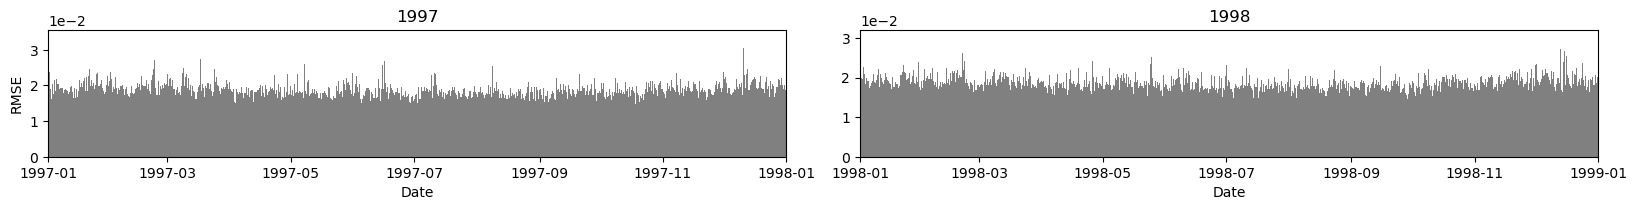

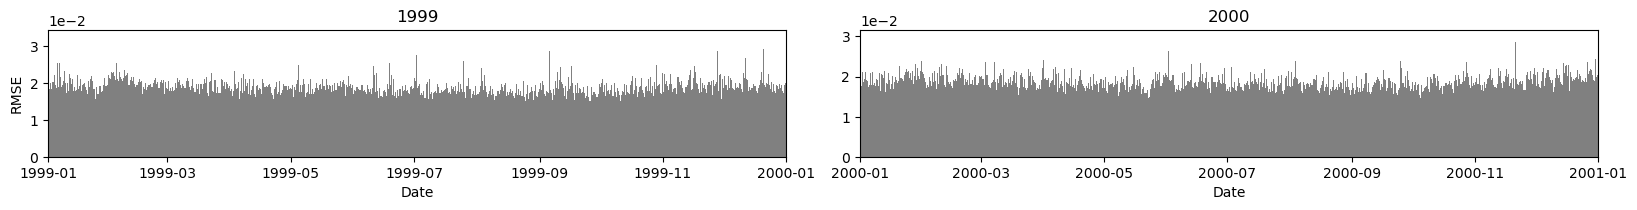

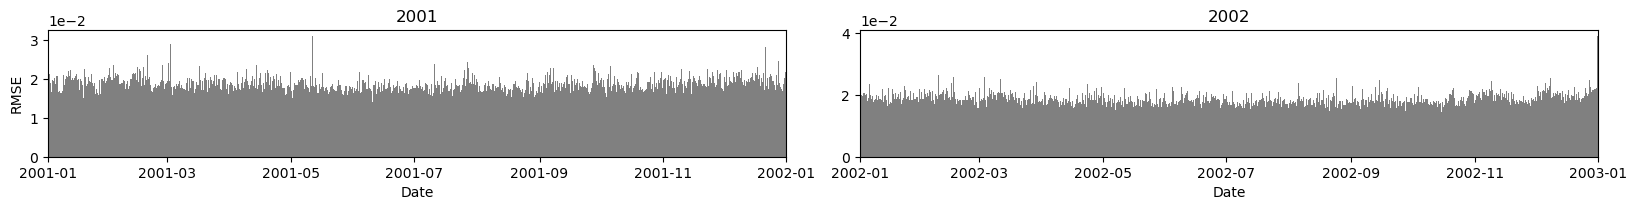

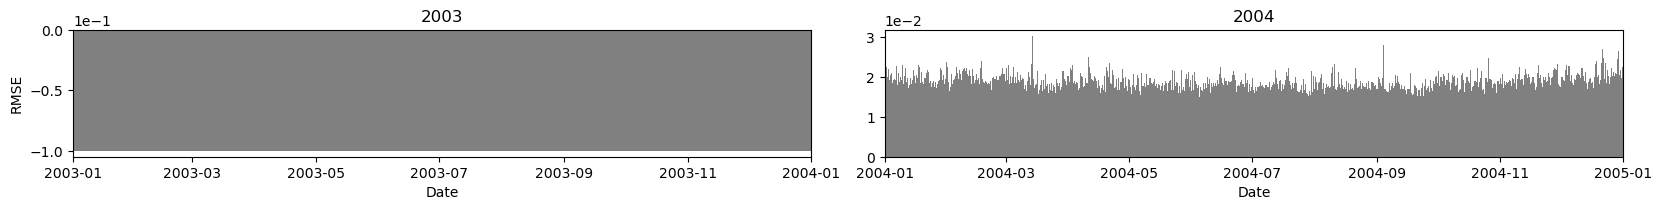

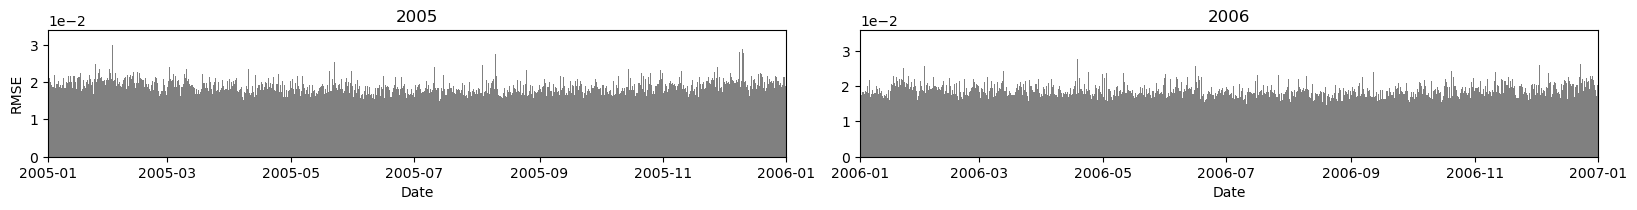

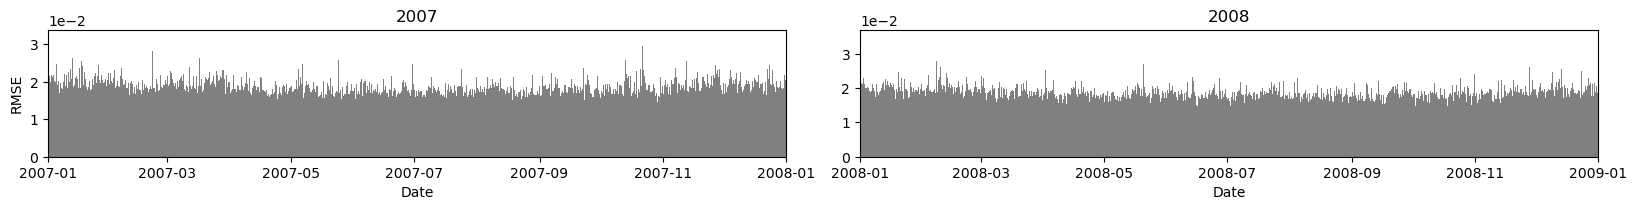

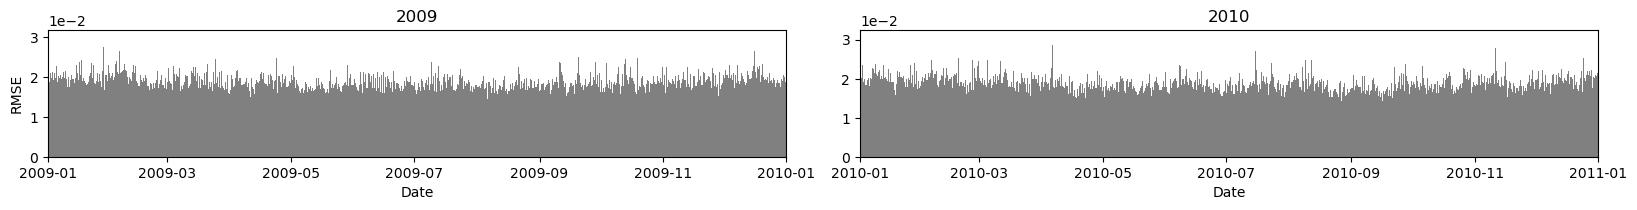

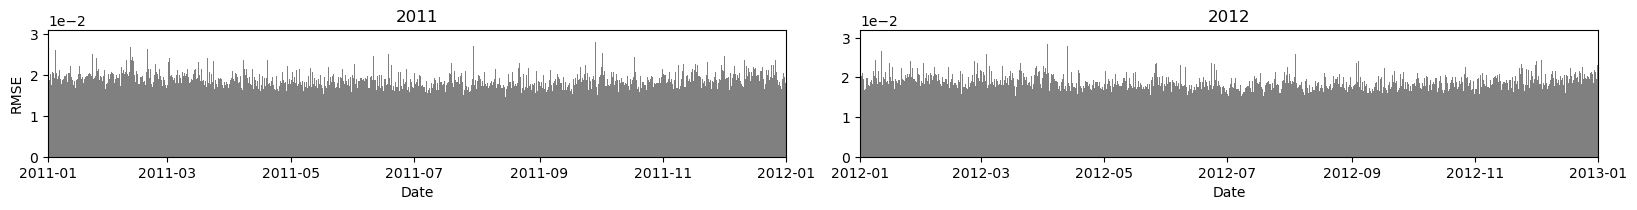

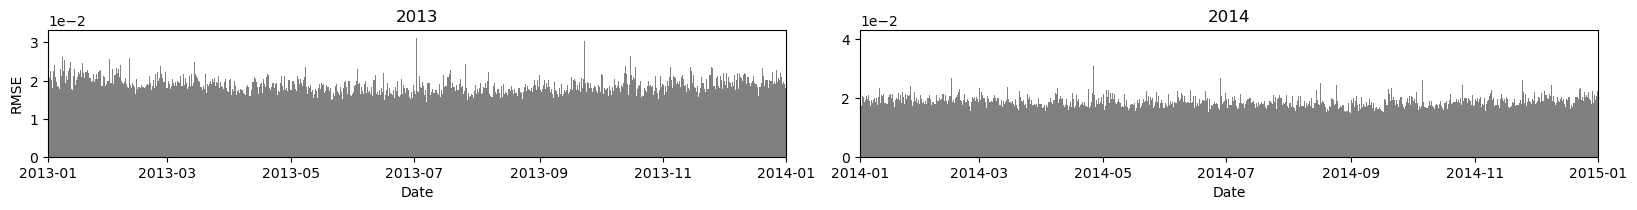

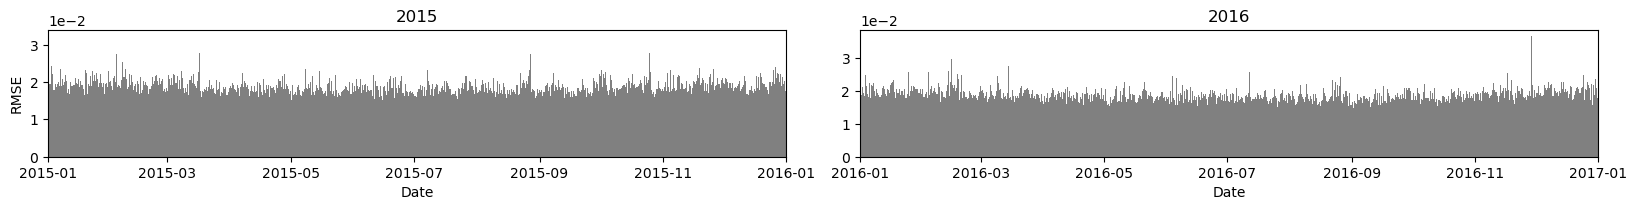

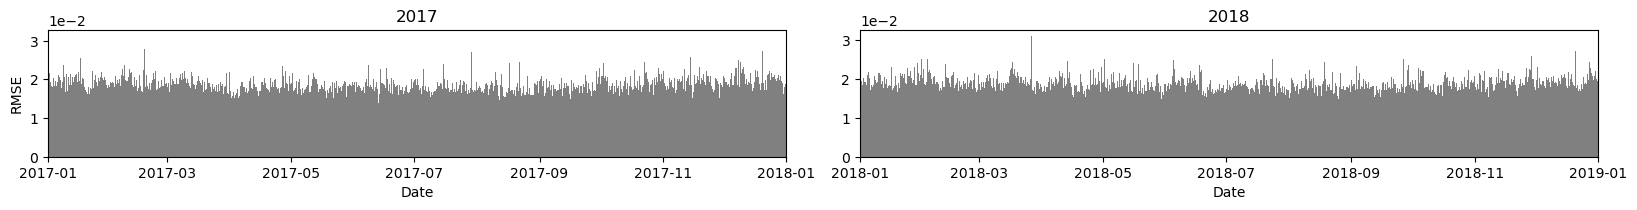

CPU times: user 8min 30s, sys: 1.73 s, total: 8min 31s
Wall time: 8min 31s


In [5]:
%%time
 
for i in  range (0, len(time_list), 2 ):
    display_hourly_rmse_double(time_list[i], rmse_list[i], time_list[i+1], rmse_list[i+1])
 

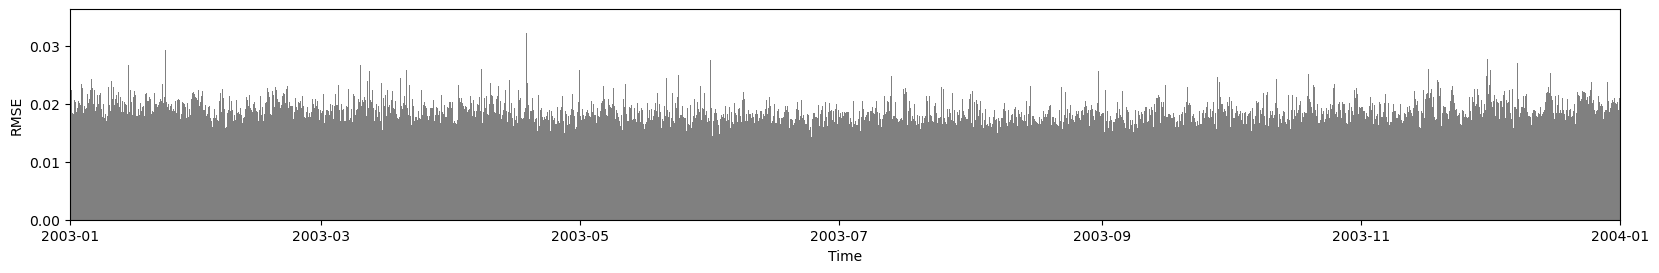

In [5]:
display_hourly_rmse(time_list[24], rmse_list[24])

In [10]:
file = "/g/data/rt52/era5/single-levels/reanalysis/10v/2003/*"
data = xr.open_mfdataset(file)
data["v10"][0]

<xarray.DataArray 'v10' (latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2003-01-01
Attributes:
    units:      m s**-1
    long_name:  10 metre V wind component

In [11]:
import traceback

def hourly_rmse_a_year_single_with_error (y1, y2):
    rmse_list = []
    
    ds_wb  = xr.open_dataset( y1 )
    ds_NCI = xr.open_dataset( y2 ) 
    
    ds_wb  =  ds_wb[p_id]  
    ds_NCI =  ds_NCI[p_id] 
    
    date_times = ds_wb.time
    
    for dt in date_times:
        RMSE = -1.0
        try:
            a =  ds_wb.sel(time=dt)
            b =  ds_NCI.sel(time=dt)  
            print ("wb:" , a)
            print ("NCI:", b)
            RMSE = math.sqrt(  np.square(np.subtract(a , b)).mean() )
        except Exception as e:
            print (e)
            print(traceback.format_exc())  
            break
            RMSE = -0.1
        rmse_list.append(RMSE) 
       
    ds_wb.close()
    ds_NCI.close()  
    return rmse_list, date_times    

In [15]:
dir_NCI = "/g/data/wb00/admin/testing/NCI_weatherbench/5.625deg"
dir_wb  = "/g/data/wb00/admin/testing/weatherbench/5.625deg"
p_name  = '10m_v_component_of_wind'
p_id    = 'v10'
year    = 2003
 
y1 = (dir_wb  + '/'+p_name+'/'+p_name+'_'+ str(year) + '_5.625deg.nc')
y2 = (dir_NCI + '/'+p_name+'/'+p_name+'_'+ str(year) + '_5.625deg.nc')
x,y = hourly_rmse_a_year_single_with_error (y1, y2)            

wb: <xarray.DataArray 'v10' (lat: 32, lon: 64)>
[2048 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    time     datetime64[ns] 2003-01-01
Attributes:
    units:      m s**-1
    long_name:  10 metre V wind component
NCI: <xarray.DataArray 'v10' (lat: 32, lon: 64)>
[2048 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2003-01-01
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
cannot reindex or align along dimension 'lon' because the (pandas) index has duplicate values
Traceback (most recent call last):
  File "/jobfs/84843163.gadi-pbs/ipykernel_82164/2257781597.py", line 21, in hourly_rmse_a_year_single_with_error
    RMSE = math.sqrt(  np.square(np.subtract(a , b)).mean() )
  File "/scratch/fp0/mah900/env/weatherb